In [1]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd
from Utilities import *
from ModelTest import loadTestSets

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load Feather data

In [3]:
# Info on what's available
feather_wsns = ["ktl", "grzl"]

# Choose a network
df_feather_ktl = pd.read_csv("../output/feather/%s.csv" % feather_wsns[0])
times = pd.to_datetime(df_feather_ktl["time"])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values

In [ ]:
n_LF = 3
sensors = [0, 1, 3]
max_it = 300

ti, tf = 15005, 15205
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti])

X_hat, sigma_smooth, sigma_filt, A, B, C, D, Q, R, pi0, sigma0 = ssm_em_stable(Y, U, V, n_LF, max_it)

Y_hat = np.dot(C, X_hat) + np.dot(D, V)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [ ]:
for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=3.0, color=c)

plt.xlim(0, tf-ti)

(0, 200)

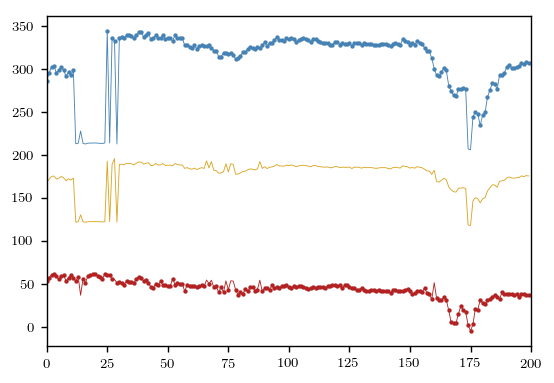

In [95]:
C, X_PCA, Y_imp = pca_est_MD(Y, n_LF, max_it)

for s, c in zip(range(n_sensors), colors):
    plt.plot(Y_imp[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=3.0, color=c)
    
plt.xlim(0, tf-ti)

In [63]:
print A, "\n", B, "\n", C, "\n", D, "\n", R

[[ 0.95331741]] 
[[ 0.]] 
[[-0.46320393]
 [-1.02519877]
 [ 1.00250249]
 [-0.66183604]
 [-0.05667192]
 [-0.08041352]
 [-0.05751178]
 [-0.08253607]
 [ 1.00250249]
 [-0.07621019]
 [-0.49054386]] 
[[  9.43211396e+02]
 [  1.80149261e+03]
 [  1.51333359e+00]
 [  1.16565550e+03]
 [  2.13492699e+03]
 [  1.41048425e+03]
 [  2.45944198e+03]
 [  2.45683162e+03]
 [  1.51333359e+00]
 [  1.44607560e+03]
 [  1.32662853e+03]] 
[[  759.58991379     0.             0.             0.             0.             0.
      0.             0.             0.             0.             0.        ]
 [    0.            15.66213683     0.             0.             0.             0.
      0.             0.             0.             0.             0.        ]
 [    0.             0.            10.47372055     0.             0.             0.
      0.             0.             0.             0.             0.        ]
 [    0.             0.             0.            97.93252058     0.             0.
      0.       

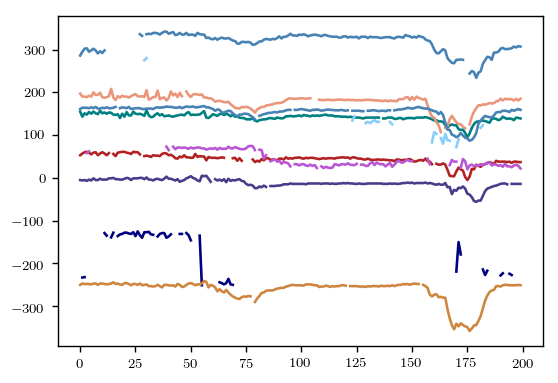

In [72]:
#ti, tf = 27005, 27500
#ti, tf = 27015, 27055 # ~ night
#ti, tf = 27065, 27105 # ~ day
ti, tf = 15005, 15205 # ~ 2 full days

plt.plot(y_sd_raw[ti:tf, :])